# SMS Spam Classification using Multinomial Naive Bayes

In this project, we will create three models based on Multinomial NB which differs on the basis of features. 

First model will classify using the standard formula for Multinomial Naive Bayes.

The second model will take in account the length of documents as feature, since length have a visible effect on class (Spam or Ham) as shown in the graph you will see shortly.

```
P(cl|doc,len) = (P(doc,len|cl) * P(cl)) / P(doc,len)
              = (P(doc|cl) * P(len|cl) * P(cl)) / (P(doc) * P(len))
              = (P(doc|cl) * P(cl)) / P(doc) * P(len|cl) / P(len)
              = P(cl|doc) * P(len|cl) / P(len)
```
              


The third model will take in account the length as well as the term frequency as features for classification.

In [48]:
# Importing Necessary Modules

import pandas as pd
import string
from nltk.corpus import stopwords
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re

### Reading Data

We will read the raw text file and store the data in an organized way into a csv. We will create a column SPAM. Inside the SPAM column, 1 denotes that the document is spam, 0 denotes it is not spam.

In [3]:
data_file = 'SMSSpamCollection.txt'

with open(data_file,'r') as f:
    csv_file = open("data.csv", "w+") 
    columnTitleRow = "SMS,SPAM\n"
    csv_file.write(columnTitleRow)
    counter = 0
    spamCounter = 0
    hamCounter = 0
    for line in f:
        counter+=1
        if counter%500==0:
            print(counter," Rows Written")
        if 'spam' in line[:4]:
            line = line[4:]
            t=1
            spamCounter+=1
        else:
            line = line[3:]
            t=0
            hamCounter+=1
        row = line.replace("\n","").replace(",","").replace("\t","") + "," + str(t) + "\n"
        csv_file.write(row)
csv_file.close()

print("Total Spam SMS: ",spamCounter)
print("Total Ham SMS: ",hamCounter)

500  Rows Written
1000  Rows Written
1500  Rows Written
2000  Rows Written
2500  Rows Written
3000  Rows Written
3500  Rows Written
4000  Rows Written
4500  Rows Written
5000  Rows Written
5500  Rows Written
Total Spam SMS:  747
Total Ham SMS:  4827


### Loading Dataset 

Now let's load data into dataframe from the csv we created above

In [18]:
df = pd.read_csv('data.csv')
print(df.head(5))

                                                 SMS  SPAM
0  Go until jurong point crazy.. Available only i...     0
1                      Ok lar... Joking wif u oni...     0
2  Free entry in 2 a wkly comp to win FA Cup fina...     1
3  U dun say so early hor... U c already then say...     0
4  Nah I don't think he goes to usf he lives arou...     0


### Extracting New Feature

Creating a new feature LENGTH, which will be used as a feature to demonstrate the improvement in accuracy. It can be clearly seen in scatterplot that for spam sms, the length is not more than 200. For Hams, the legth goes upto 910.

In [19]:
df['LENGTH'] = df['SMS'].apply(len)
print(df.head())
print("\n")
print("Max length of HAM: ",df[(df['SPAM']==0)].LENGTH.max())
print("Max length of SPAM: ",df[(df['SPAM']==1)].LENGTH.max())

                                                 SMS  SPAM  LENGTH
0  Go until jurong point crazy.. Available only i...     0     110
1                      Ok lar... Joking wif u oni...     0      29
2  Free entry in 2 a wkly comp to win FA Cup fina...     1     155
3  U dun say so early hor... U c already then say...     0      49
4  Nah I don't think he goes to usf he lives arou...     0      60


Max length of HAM:  910
Max length of SPAM:  222


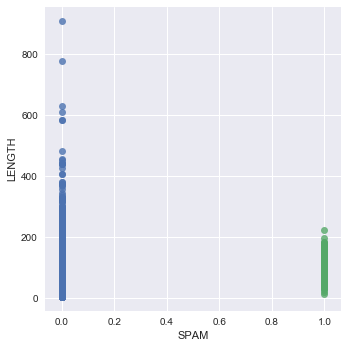

In [7]:
sns.lmplot( x="SPAM", y="LENGTH", data=df, fit_reg=False, hue='SPAM', legend=False)
sns.plt.show()

#### Removing Punctuations and changing to lower case


 


In [68]:
df['SMS'] = df['SMS'].str.lower()
df['SMS'] = df['SMS'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

## Creating our classifier

Following is our custom NB classifier class that will provide some usefull apis too.

In [137]:
class NaiveBayes:
    def __init__(self):
        
        # All variables used in calculations are kept private
        self.__TOTAL_SPAM = 0
        self.__TOTAL_HAM = 0
        self.__PRIOR_SPAM = 0
        self.__PRIOR_HAM = 0
        self.__TERMS_IN_SPAM = 0
        self.__TERMS_IN_HAM = 0
        self.__TOTAL_TERMS_IN_SPAM = 0
        self.__TOTAL_TERMS_IN_HAM = 0
        self.__AVG_LENGTH_SPAM = 0
        self.__AVG_LENGTH_HAM = 0
        self.__V = 0
        self.__SPAM_VOCAB = 0
        self.__HAM_VOCAB = 0
        self.mode = 0

    # Api to split data in training and validation datasets
    def split_data(self,df,ratio):
        df_size = len(df.index)
        return df.iloc[int(df_size * ratio):] , df.iloc[:int(df_size * ratio)]
    
    # Method to train our classifier
    # Mode == 0 => Standard NB
    # Mode == 1 => Standard NB + Length as Feature
    # Mode == 2 => Standard NB + Length and Term Frequency as Features
    def fit(self, df, mode):
        self.mode = mode
        data_info = training_df.groupby('SPAM').size()

        self.__TOTAL_SPAM = data_info[1]
        self.__TOTAL_HAM = data_info[0]
        self.__PRIOR_SPAM = self.__TOTAL_SPAM/(self.__TOTAL_SPAM + self.__TOTAL_HAM)
        self.__PRIOR_HAM = self.__TOTAL_HAM/(self.__TOTAL_SPAM + self.__TOTAL_HAM)

        spam_df = df[df['SPAM']==1]
        ham_df = df[df['SPAM']==0]

        if mode == 1:
            self.__AVG_LENGTH_SPAM = spam_df['LENGTH'].mean()
            self.__AVG_LENGTH_HAM = ham_df['LENGTH'].mean()


        self.__SPAM_VOCAB = collections.Counter([y for x in spam_df['SMS'].tolist() for y in x.split(" ") ])
        self.__HAM_VOCAB = collections.Counter([y for x in ham_df['SMS'].tolist() for y in x.split(" ") ]) 

        self.__TERMS_IN_SPAM = len(self.__SPAM_VOCAB)
        self.__TERMS_IN_HAM = len(self.__HAM_VOCAB)
        self.__TOTAL_TERMS_IN_SPAM = len(spam_df.index)
        self.__TOTAL_TERMS_IN_HAM = len(ham_df.index)

        self.__V = self.__TERMS_IN_SPAM + self.__TERMS_IN_HAM
            
        
        
   # Method to predict any single SMS     
    def predict(self,sms):
        sms = sms.lower()
        sms = [''.join(c for c in s if c not in string.punctuation) for s in sms]
        sms = ''.join(sms).split(" ")
        spam_prob = self.__PRIOR_SPAM
        ham_prob = self.__PRIOR_HAM

        most_common_spam = self.__SPAM_VOCAB.most_common(1)[0][1]
        most_common_ham = self.__HAM_VOCAB.most_common(1)[0][1]
        
        for term in sms:
            if self.mode == 1:
                spam_prob = spam_prob * ( (self.__SPAM_VOCAB[term] + 1) / (self.__TERMS_IN_SPAM + self.__V) ) * ( (self.__AVG_LENGTH_SPAM + 1) / (len(sms) + 1) )
                ham_prob = ham_prob * ( (self.__HAM_VOCAB[term] + 1) / (self.__TERMS_IN_HAM + self.__V) ) * ( (self.__AVG_LENGTH_HAM + 1) / (len(sms) + 1) )

            if self.mode == 2:
                spam_prob = spam_prob * ( (self.__SPAM_VOCAB[term] + 1) / (self.__TERMS_IN_SPAM + self.__V) ) * ( (self.__AVG_LENGTH_SPAM + 1) / (len(sms) + 1) ) * ( (self.__SPAM_VOCAB[term] + 1) / most_common_spam )    
                ham_prob = ham_prob * ( (self.__HAM_VOCAB[term] + 1) / (self.__TERMS_IN_HAM + self.__V) ) * ( (self.__AVG_LENGTH_HAM + 1) / (len(sms) + 1) )  * ( (self.__HAM_VOCAB[term] + 1) / most_common_ham)
                
                
            else:
                spam_prob = spam_prob * ( (self.__SPAM_VOCAB[term] + 1) / (self.__TERMS_IN_SPAM + self.__V) )
                ham_prob = ham_prob * ( (self.__HAM_VOCAB[term] + 1) / (self.__TERMS_IN_HAM + self.__V) )  

            
        if spam_prob>ham_prob:
            return 1
        else:
            return 0
    
    
    # Method to perform validation in batch
    def validate(self,df):
        total = 0
        correct = 0
        correct_spam = 0
        correct_ham = 0
        for index, row in df.iterrows():
            if self.predict(row['SMS'])==row['SPAM']:
                correct+=1
                if row['SPAM'] == 1:
                    correct_spam = correct_spam+1
                else:
                    correct_ham = correct_ham+1

            total+=1
            if(total%50==0):
                print("Querries Processed: ",total)

        print("Accuracy: ",round((correct/total)*100, 2),"%")
        print("Correct Predictions: ",correct,"/",len(df.index))

        data_info = df.groupby('SPAM').size()
        TOTAL_SPAM = data_info[1]
        TOTAL_HAM = data_info[0]    

        print("Confusion Matrix")
        print("[",correct_spam,TOTAL_SPAM,"]\n[",correct_ham,TOTAL_HAM,"]")

    
    
    def most_common_spam(self,num):
        try:
            print("\n======= Most Common Spam Terms & their Frequency=======\n\n")
            for term, freq in self.__SPAM_VOCAB.most_common(num):
                print(term, freq)
            
        except:
            print("Vocab Empty!")
        
    def most_common_ham(self,num):
        try:
            print("\n======= Most Common Ham Terms & their Frequency=======\n\n")
            for term, freq in self.__HAM_VOCAB.most_common(num):
                print(term, freq)        
        except:
            print("Vocab Empty!")
            
    def save_model(self):
        with open("model.txt","w+") as f:
            f.write(str(self.__TOTAL_SPAM))
            f.write("\n")
            f.write(str(self.__TOTAL_HAM))
            f.write("\n")            
            f.write(str(self.__PRIOR_SPAM))
            f.write("\n")
            f.write(str(self.__PRIOR_HAM))
            f.write("\n")
            f.write(str(self.__TERMS_IN_SPAM))
            f.write("\n")
            f.write(str(self.__TERMS_IN_HAM))
            f.write("\n")            
            f.write(str(self.__TOTAL_TERMS_IN_SPAM))
            f.write("\n")
            f.write(str(self.__TOTAL_TERMS_IN_HAM))
            f.write("\n")    
            f.write(str(self.__AVG_LENGTH_SPAM))
            f.write("\n")
            f.write(str(self.__AVG_LENGTH_HAM))
            f.write("\n")
            f.write(str(self.__V))
            f.write("\n")
            f.write(str(self.__SPAM_VOCAB))
            f.write("\n")            
            f.write(str(self.__HAM_VOCAB))
        print("Model Saved!")


                
                
                

Now Lets test our classifier. First split data into training and testing sets

In [138]:
nb = NaiveBayes()
# 10% for validation, 90% for training
validation_data, training_data = nb.split_data(df,0.90)

### Model with standard Multinomial NB

In [139]:
# Training our classifier
nb.fit(training_data,0)
# Validating Our Classifier
nb.validate(validation_data)

Querries Processed:  50
Querries Processed:  100
Querries Processed:  150
Querries Processed:  200
Querries Processed:  250
Querries Processed:  300
Querries Processed:  350
Querries Processed:  400
Querries Processed:  450
Querries Processed:  500
Querries Processed:  550
Accuracy:  96.42 %
Correct Predictions:  538 / 558
Confusion Matrix
[ 52 72 ]
[ 486 486 ]


### Multinomial NB with LENGTH of documents as Feature

In [140]:
# Training our classifier
nb.fit(training_data,1)
# Validating Our Classifier
nb.validate(validation_data)

Querries Processed:  50
Querries Processed:  100
Querries Processed:  150
Querries Processed:  200
Querries Processed:  250
Querries Processed:  300
Querries Processed:  350
Querries Processed:  400
Querries Processed:  450
Querries Processed:  500
Querries Processed:  550
Accuracy:  98.39 %
Correct Predictions:  549 / 558
Confusion Matrix
[ 65 72 ]
[ 484 486 ]


### Multinomial NB with LENGTH of documents and Term Frequencty as Features

In [141]:
# Training our classifier
nb.fit(training_data,2)
# Validating Our Classifier
nb.validate(validation_data)

Querries Processed:  50
Querries Processed:  100
Querries Processed:  150
Querries Processed:  200
Querries Processed:  250
Querries Processed:  300
Querries Processed:  350
Querries Processed:  400
Querries Processed:  450
Querries Processed:  500
Querries Processed:  550
Accuracy:  98.21 %
Correct Predictions:  548 / 558
Confusion Matrix
[ 70 72 ]
[ 478 486 ]


Most common N terms in spams and hams

In [143]:
nb.most_common_spam(10)
nb.most_common_ham(10)


======= Most Common Spam Terms & their Frequency=======


to 624
a 343
call 304
you 258
your 234
 227
free 190
the 182
now 176
for 176

======= Most Common Ham Terms & their Frequency=======


i 1963
you 1656
 1435
to 1423
the 1022
a 960
u 888
and 776
in 733
me 687


## Conclusion

It is clear from the results that the accuracy is increase around 2% as we introduced two new features in the multinomial naive bayes classifier